따릉이 데이터를 활용한 데이터 분석

각 날짜의 1시간 전의 기상상황을 가지고 1시간 후의 따릉이 대여수를 예측해보세요

1.라이브러리 및 데이터 Labrary & Data

# 1. 라이브러리 및 데이터
# Library & Data

In [69]:
import pandas as pd #판다스 패키지 불러오기
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor #랜덤 포레스트 불러오기
import seaborn as sns #seaborn 패키지 불러오기
import matplotlib.pyplot as plt #멧플릿 패키지 불러오기

In [70]:
# 데이터 불러오기
train = pd.read_csv('C:/Users/KGH/Desktop/data/제공데이터/train.csv')# 모델 학습 파일
test = pd.read_csv('C:/Users/KGH/Desktop/data/제공데이터/test.csv')# 모델 시험지 파일
submission = pd.read_csv('C:/Users/KGH/Desktop/data/제공데이터/submission.csv')#답안지 파일
newtrain = pd.read_csv('C:/Users/KGH/Desktop/data/가공데이터/newtrain.csv',encoding='cp949' )# 직접 만든 모델 학습 파일
newtest = pd.read_csv('C:/Users/KGH/Desktop/data/가공데이터/newtest.csv',encoding='cp949' )# 직접 만든 모델 학습 파일

# 2. 탐색적 자료분석
# Exploratory Data Analysis (EDA)

# newtrain는 train 데이터에서 934, 1035행의 온도, 풍속, 가시성, 습도, precipitation 값을 채워준 데이터

In [71]:
newtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1459 non-null   int64  
 1   id                        1459 non-null   int64  
 2   hour                      1459 non-null   int64  
 3   date                      1459 non-null   object 
 4   day                       1459 non-null   object 
 5   hour_bef_temperature      1459 non-null   float64
 6   hour_bef_windspeed        1452 non-null   float64
 7   hour_bef_humidity         1459 non-null   int64  
 8   hour_bef_visibility       1459 non-null   int64  
 9   hour_bef_precipitation.x  1459 non-null   int64  
 10  hour_bef_precipitation.y  1459 non-null   float64
 11  hour_bef_ozone            1383 non-null   float64
 12  hour_bef_pm10             1369 non-null   float64
 13  hour_bef_pm2.5            1342 non-null   float64
 14  count   

* id : 날짜와 시간별 id
* hour : 따릉이를 이용하였을 때 1시간 전 시간
* date : 따릉이를 이용하였을 때 1시간 전 날짜
* day : 따릉이를 이용하였을 때 1시간 전 요일 
* hour_bef_temperature : 1시간 전 기온
* hour_bef_precipitation.x : 1시간 전 비 정보, 비가 오지 않았으면 0, 비가 오면 1
* hour_bef_precipitation.y : 1시간 전 비 강수량
* hour_bef_windspeed : 1시간 전 풍속(평균)
* hour_bef_humidity : 1시간 전 습도
* hour_bef_visibility : 1시간 전 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
* hour_bef_ozone : 1시간 전 오존
* hour_bef_pm10 : 1시간 전 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* hour_bef_pm2.5 : 1시간 전 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* count : 시간에 따른 따릉이 대여 수
* weekend : 1시간 전 주말 정보, 주말이면 1. 주말이 아니면 0

# 결측치가 있는 행을 모두 제거한 데이터 만들기

In [72]:
train_no_NA=train.copy().dropna() #결측치가 있는 행을 모두 제거한다.

# 각 변수 간 상관계수 구하기

<AxesSubplot:>

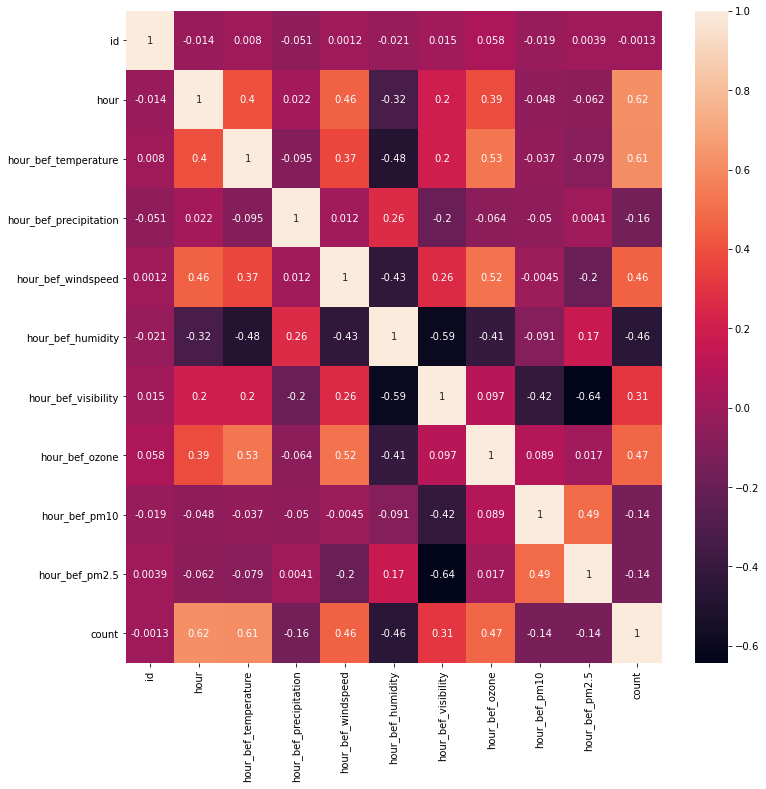

In [73]:
import seaborn as sns #seaborn 패키지 불러오기
plt.figure(figsize = (12, 12)) #그림 크기 늘리기
sns.heatmap(train_no_NA.corr(), annot = True) #상관계수 한번에 확인하기
 # annot=True를 써야만 상관계수 수치가 표시 됨

#상관계수가 높은 것들 (상관계수가 0.5이상인 것만 추리기)
1.hour-count 0.62
2.hour_bef_temperature-hour_bef_ozone 0.53 3.hour_bef_temperature-count 0.61
4.hour_bef_windspeed-hour_bef_ozone 0.52
5.hour_bef_humidity-hour_bef_visibility -0.59
6.hour_bef_visibility-hour_bef_pm2.5 -0.64
#count와 상관계수가 높은 것들
1.hour 0.62
2.hour_bef_temperature 0.61
3.hour_bef_windspeed 0.46
4.hour_bef_humidity -0.46
5.hour_bef_ozone 0.47
#상관계수가 0.4이상인 것들
1.시간-온도(0.4) 2.시간-풍속(0.46) 3.시간-수(0.62)    X              # 시간-오존(0.39)
4.온도-습도(-0.48) 5.온도-오존(0.53) 6.온도-수(0.61)                 # 온도-풍속(0.37)
7.풍속-습도(-0.43) 8.풍속-오존(0.52) 9.풍속-수(0.46)
10.습도-가시성(-0.59) 11.습도-오존(-0.41) 12.습도-수(-0.46)
13.가시성-pm10(-0.42) 14.가시성-pm2.5(-0.64)
15.오존-수(0.47)
16.pm10-pm2.5(0.49)

In [74]:
newtrain_copy=newtrain.copy() #newtrain 데이터 복사

# newtrain_copy 데이터의 각 변수들의 결측치 수

In [75]:
newtrain_copy.isna().sum()

Unnamed: 0                    0
id                            0
hour                          0
date                          0
day                           0
hour_bef_temperature          0
hour_bef_windspeed            7
hour_bef_humidity             0
hour_bef_visibility           0
hour_bef_precipitation.x      0
hour_bef_precipitation.y      0
hour_bef_ozone               76
hour_bef_pm10                90
hour_bef_pm2.5              117
count                         0
weekend                       0
dtype: int64

# 시간 분포

<AxesSubplot:ylabel='Frequency'>

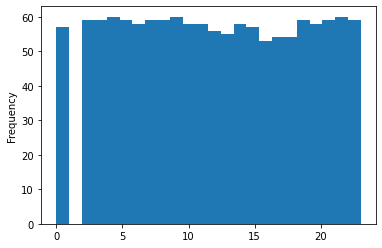

In [76]:
train_no_NA["hour"].plot(kind="hist", bins=24)

# 풍속 분포

<AxesSubplot:ylabel='Frequency'>

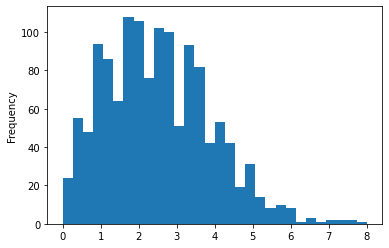

In [77]:
train_no_NA["hour_bef_windspeed"].plot(kind="hist", bins=30)

# 시간 별 풍속 중앙값으로 결측치 대체 (상관계수 0.46)

In [78]:
newtrain[newtrain["hour_bef_windspeed"].isna()] #hour_bef_windspeed의 결측치 확인

,Unnamed: 0,id,hour,date,day,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_precipitation.x,hour_bef_precipitation.y,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,weekend
368,369,1717,12,2017-04-16,일요일,21.4,NaN,44,1375,0,0.0,0.044,61.0,37.0,116,1
369,370,33,13,2017-04-16,일요일,22.6,NaN,41,987,0,0.0,0.046,64.0,39.0,208,1
567,568,1196,20,2017-04-24,월요일,16.5,NaN,31,2000,0,0.0,0.058,39.0,18.0,181,0
571,572,570,0,2017-04-25,화요일,14.3,NaN,49,2000,0,0.0,0.044,37.0,20.0,58,0
572,573,381,1,2017-04-25,화요일,14.1,NaN,55,1992,0,0.0,NaN,NaN,NaN,38,0
573,574,1855,2,2017-04-25,화요일,14.0,NaN,52,2000,0,0.0,0.044,37.0,20.0,20,0
574,575,404,3,2017-04-25,화요일,14.0,NaN,50,2000,0,0.0,0.049,35.0,22.0,17,0


# 시간과 풍속 간의 scatterplot

<AxesSubplot:xlabel='hour', ylabel='hour_bef_windspeed'>

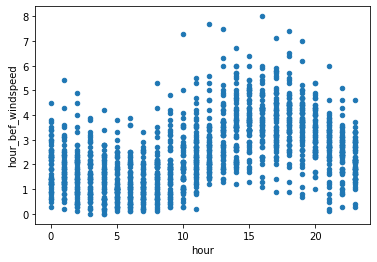

In [79]:
newtrain.plot(kind="scatter", x="hour", y="hour_bef_windspeed")  #hour과 hour_bef_speed에대한 scatterplot

# 시간 별 평균 풍속

In [80]:
newtrain.groupby("hour").mean()["hour_bef_windspeed"]

hour
0     1.969492
1     1.836667
2     1.633333
3     1.620000
4     1.409836
5     1.296721
6     1.331148
7     1.262295
8     1.632787
9     1.829508
10    2.122951
11    2.485246
12    2.766667
13    3.281356
14    3.522951
15    3.768852
16    3.820000
17    3.801667
18    3.847541
19    3.595082
20    3.278333
21    2.755000
22    2.498361
23    2.195082
Name: hour_bef_windspeed, dtype: float64

# 시간 별 풍속의 중앙값

In [81]:
newtrain.groupby("hour").median()["hour_bef_windspeed"]

hour
0     2.00
1     1.65
2     1.45
3     1.50
4     1.40
5     1.00
6     1.20
7     1.10
8     1.60
9     1.80
10    1.90
11    2.30
12    2.60
13    3.30
14    3.50
15    3.70
16    3.80
17    3.85
18    3.80
19    3.70
20    3.25
21    2.90
22    2.50
23    2.10
Name: hour_bef_windspeed, dtype: float64

# 시간 별 평균 풍속 plot

<AxesSubplot:xlabel='hour'>

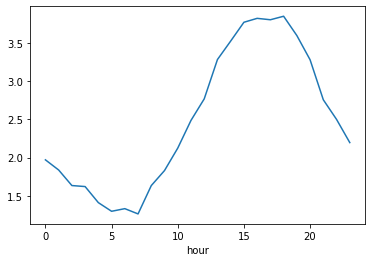

In [82]:
newtrain.groupby("hour").mean()["hour_bef_windspeed"].plot() #시간 별 평균 풍속 그래프

# 시간 별 풍속의 중앙값 plot

<AxesSubplot:xlabel='hour'>

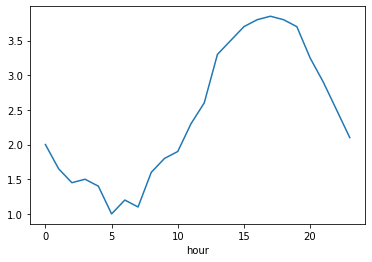

In [83]:
newtrain.groupby("hour").median()["hour_bef_windspeed"].plot() #시간 별 평균 풍속 그래프

# 시간 별 풍속의 수

In [84]:
newtrain.groupby("hour").count()["hour_bef_windspeed"]

hour
0     59
1     60
2     60
3     60
4     61
5     61
6     61
7     61
8     61
9     61
10    61
11    61
12    60
13    59
14    61
15    61
16    60
17    60
18    61
19    61
20    60
21    60
22    61
23    61
Name: hour_bef_windspeed, dtype: int64

# newtrain의 풍속 결측치 위치 확인

In [85]:
newtrain[newtrain["hour_bef_windspeed"].isna()].index #hour_bef_windspeed의 결측치 위치 확인

Int64Index([368, 369, 567, 571, 572, 573, 574], dtype='int64')

# 시간 별 풍속 중앙값으로 결측치 대체하기

In [86]:
newtrain_copy['hour_bef_windspeed'].fillna({368 : 2.60, 369 : 3.30, 567 : 3.25, 571 : 2.00, 572 : 1.65, 573 : 1.45, 574 : 1.50}, inplace=True)

In [87]:
newtrain_copy.isna().sum()

Unnamed: 0                    0
id                            0
hour                          0
date                          0
day                           0
hour_bef_temperature          0
hour_bef_windspeed            0
hour_bef_humidity             0
hour_bef_visibility           0
hour_bef_precipitation.x      0
hour_bef_precipitation.y      0
hour_bef_ozone               76
hour_bef_pm10                90
hour_bef_pm2.5              117
count                         0
weekend                       0
dtype: int64

# 오존이란?  기온이 25℃이상이고, 상대습도 75%이하일 때, 풍속 기압경도가 완만하여 풍속 4m/s이하의 약풍이 지속될 때 발생하기 좋음.
#오존(ozone, 분자식: O3)은 산소 원자 3개로 이루어져 있으며, 상온 대기압에서 푸른빛의 기체이다. 영하 112도 이하에서는 검푸른 액체이며, 영하 193도 이하로 내려가면 고체가 된다. 오존은 불안정하여 이원자의 산소로 분해되려는 경향이 있는데, 이러한 경향은 온도가 올라갈수록, 압력이 낮아질수록 강하다.
오존이 갖고 있는 강력한 산화력은 하수의 살균, 악취제거 등에 유용하게 이용되기도 하고, 지구 대기중에 오존층을 형성하여 보호막의 역할도 하는 등 좋은 역할을 하지만, 지표면에 생성되는 오존은 인간의 건강에 해로운 대기오염 물질이 된다.

# 온도 분포

<AxesSubplot:ylabel='Frequency'>

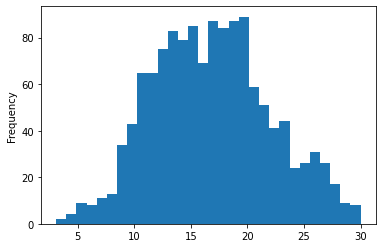

In [88]:
train_no_NA["hour_bef_temperature"].plot(kind="hist", bins=30)

# 오존 분포

<AxesSubplot:ylabel='Frequency'>

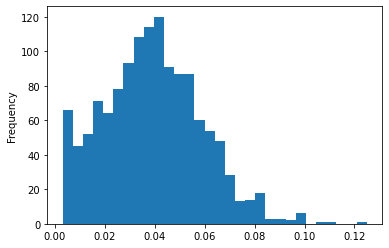

In [89]:
train_no_NA["hour_bef_ozone"].plot(kind="hist", bins=30)

# 온도 구간 별 오존 중앙값으로 결측치 대체 (상관계수 0.53)

<AxesSubplot:xlabel='hour_bef_temperature', ylabel='hour_bef_ozone'>

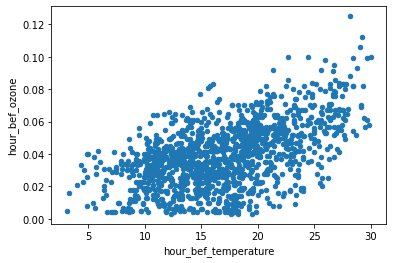

In [92]:
train_no_NA.plot(kind="scatter", x="hour_bef_temperature", y="hour_bef_ozone")  #hour_bef_ozone과 hour_bef_temperature에대한 scatterplot

<AxesSubplot:xlabel='hour_bef_temperature', ylabel='hour_bef_ozone'>

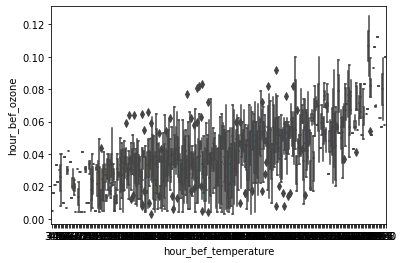

In [93]:
sns.boxplot(x = "hour_bef_temperature", y="hour_bef_ozone", data = train_no_NA) #hour_bef_ozone과 hour_bef_temperature에 따른 boxplot

# 온도를 5도 간격으로 묶어서 구간으로 만들기
#hour_bef_temperature가 0~10.0일때 hour_bef_temperature_band=1
#hour_bef_temperature가 10.1~15.0일때 hour_bef_temperature_band=2
#hour_bef_temperature가 15.1~20.0일때 hour_bef_temperature_band=3
#hour_bef_temperature가 20.1~25.0일때 hour_bef_temperature_band=4
#hour_bef_temperature가 25.1~30.0일때 hour_bef_temperature_band=5

# 온도가 0-5.0일때 개수가 12개로 적어서 구간 0-5 와 구간 5.1-10을 합침.

In [94]:
newtrain_copy["hour_bef_temperature_band"]=0
newtrain_copy.loc[newtrain_copy["hour_bef_temperature"]<=10,"hour_bef_temperature_band"]=1
newtrain_copy.loc[newtrain_copy["hour_bef_temperature"]>10,"hour_bef_temperature_band"]=2
newtrain_copy.loc[newtrain_copy["hour_bef_temperature"]>15,"hour_bef_temperature_band"]=3
newtrain_copy.loc[newtrain_copy["hour_bef_temperature"]>20,"hour_bef_temperature_band"]=4
newtrain_copy.loc[newtrain_copy["hour_bef_temperature"]>25,"hour_bef_temperature_band"]=5

# 각 온도 구간 별 오존 농도의 수

In [95]:
newtrain_copy.groupby("hour_bef_temperature_band").count()["hour_bef_ozone"] #정규분포 형태.groupby("hour_bef_temperature_band").count()["hour_bef_ozone"] #정규분포 형태

hour_bef_temperature_band
1    124
2    423
3    480
4    247
5    109
Name: hour_bef_ozone, dtype: int64

# 각 온도 구간 별 오존 농도 평균

In [96]:
newtrain_copy.groupby("hour_bef_temperature_band").mean()["hour_bef_ozone"] #각 온도 구간 별 오존 농도 평균

hour_bef_temperature_band
1    0.023266
2    0.032858
3    0.037142
4    0.049943
5    0.066009
Name: hour_bef_ozone, dtype: float64

# 각 온도 구간 별 오존 농도 중앙값

In [97]:
newtrain_copy.groupby("hour_bef_temperature_band").median()["hour_bef_ozone"] #각 온도 구간 별 오존 농도 중앙값

hour_bef_temperature_band
1    0.0235
2    0.0340
3    0.0380
4    0.0510
5    0.0650
Name: hour_bef_ozone, dtype: float64

# 각 온도 구간 별 오존 농도 평균 plot

<AxesSubplot:xlabel='hour_bef_temperature_band'>

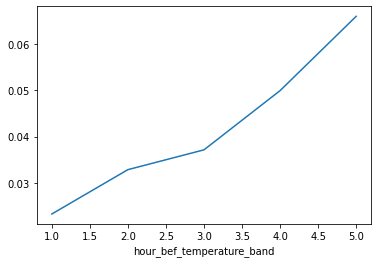

In [98]:
newtrain_copy.groupby("hour_bef_temperature_band").mean()["hour_bef_ozone"].plot() #각 온도 구간 별 오존 농도 평균 그래프

# 각 온도 구간 별 오존 농도 중앙값 plot

<AxesSubplot:xlabel='hour_bef_temperature_band'>

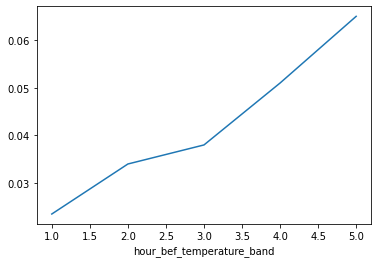

In [99]:
newtrain_copy.groupby("hour_bef_temperature_band").median()["hour_bef_ozone"].plot() #각 온도 구간 별 오존 농도 중앙값 그래프

#pd.set_option("display.max_rows", None) #모든 행을 보여줌

# 구간 별 오존 농도 중앙값 변수 만들기

In [100]:
newtrain_copy["hour_bef_ozone_median"]=0
newtrain_copy.loc[newtrain_copy["hour_bef_temperature"]<=10,"hour_bef_ozone_median"]=0.0235
newtrain_copy.loc[newtrain_copy["hour_bef_temperature"]>10,"hour_bef_ozone_median"]=0.0340
newtrain_copy.loc[newtrain_copy["hour_bef_temperature"]>15,"hour_bef_ozone_median"]=0.0380
newtrain_copy.loc[newtrain_copy["hour_bef_temperature"]>20,"hour_bef_ozone_median"]=0.0510
newtrain_copy.loc[newtrain_copy["hour_bef_temperature"]>25,"hour_bef_ozone_median"]=0.0650

# 결측치인 행 hour_bef_ozone_median 값으로 대체하기

In [101]:
temp=list(range(1459))
newtrain_copy['hour_bef_ozone']
newtrain_copy['hour_bef_ozone_median']
for i in range(1459):
  if newtrain_copy['hour_bef_ozone'][i]>0:
    temp[i] = newtrain_copy['hour_bef_ozone'][i]
  else:
    temp[i] = newtrain_copy['hour_bef_ozone_median'][i]

In [102]:
newtrain_copy['hour_bef_ozone']=temp

# 오존 농도의 결측치가 대체 되었는지 확인

In [103]:
newtrain_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 1459 non-null   int64  
 1   id                         1459 non-null   int64  
 2   hour                       1459 non-null   int64  
 3   date                       1459 non-null   object 
 4   day                        1459 non-null   object 
 5   hour_bef_temperature       1459 non-null   float64
 6   hour_bef_windspeed         1459 non-null   float64
 7   hour_bef_humidity          1459 non-null   int64  
 8   hour_bef_visibility        1459 non-null   int64  
 9   hour_bef_precipitation.x   1459 non-null   int64  
 10  hour_bef_precipitation.y   1459 non-null   float64
 11  hour_bef_ozone             1459 non-null   float64
 12  hour_bef_pm10              1369 non-null   float64
 13  hour_bef_pm2.5             1342 non-null   float

# 시정이란(가시성)?
기상학에서 시정(視程)은 물체나 빛이 분명하게 보이는 최대 거리(가시거리, 문화어: 눈보기거리)의 측정 기준이다. 즉, 대기가 혼탁한 정도를 눈에 보이는 곳까지의 거리로 나타낸 것을 이르는 말이다. 가시(可視), 가시도라고도 부른다. 일반적으로 시정은 수평 방향의 시정을 말한다.
시정은 공기의 혼탁한 정도를 나타내는 척도의 하나로 사용된다. 시정은 습도와 대기오염 물질 등에 따라 변하며 항공기·선박·자동차 등 교통기관의 운행 등에 직접적인 영향을 미친다.

1.가시거리 저하는 주로 습도가 높고 바람이 약한 날에 발생하는 안개로 인해 나타남.
2.미세먼지(PM2.5) 농도가 높아지면 미세먼지 입자에 의해 빛이 산란되거나 흡수돼 시정이 감소한다.
3.미세먼지 농도가 높은 상태에서 습도가 높아지면 시정은 더 나빠진다.

# 가시성 분포

<AxesSubplot:ylabel='Frequency'>

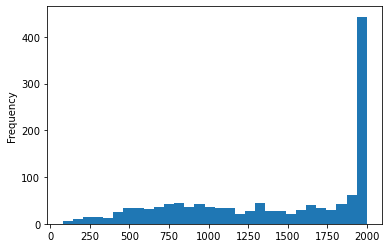

In [104]:
train_no_NA["hour_bef_visibility"].plot(kind="hist", bins=30)

# pm2.5 분포

<AxesSubplot:ylabel='Frequency'>

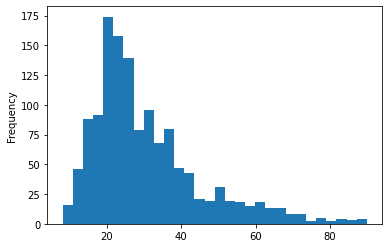

In [105]:
train_no_NA["hour_bef_pm2.5"].plot(kind="hist", bins=30)

# 가시성 구간 별 pm2.5 중앙값으로 결측치 대체 (상관계수 -0.64)

<AxesSubplot:xlabel='hour_bef_visibility', ylabel='hour_bef_pm2.5'>

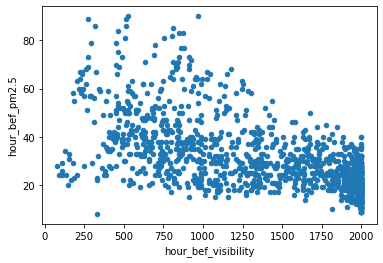

In [106]:
train_no_NA.plot(kind="scatter", x="hour_bef_visibility", y="hour_bef_pm2.5")  #hour_bef_visibility과 hour_bef_pm2.5에대한 scatterplot

<AxesSubplot:xlabel='hour_bef_visibility', ylabel='hour_bef_pm2.5'>

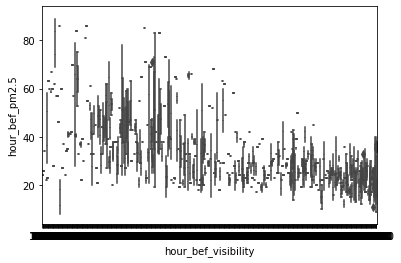

In [107]:
sns.boxplot(x = "hour_bef_visibility", y="hour_bef_pm2.5", data = train_no_NA) #hour_bef_visibility과 hour_bef_pm2.5에 따른 boxplot

# 가시성을 100 간격으로 묶어서 구간으로 만들기
#hour_bef_visibility가 0~100.0일때 hour_bef_visibility_band=1
#hour_bef_visibility가 100.1~200.0일때 hour_bef_visibility_band=2
#hour_bef_visibility가 200.1~300.0일때 hour_bef_visibility_band=3
#hour_bef_visibility가 300.1~400.0일때 hour_bef_visibility_band=4
#hour_bef_visibility가 400.1~500.0일때 hour_bef_visibility_band=5
#hour_bef_visibility가 500.1~600.0일때 hour_bef_visibility_band=6
#hour_bef_visibility가 600.1~700.0일때 hour_bef_visibility_band=7
#hour_bef_visibility가 700.1~800.0일때 hour_bef_visibility_band=8
#hour_bef_visibility가 800.1~900.0일때 hour_bef_visibility_band=9
#hour_bef_visibility가 900.1~1000.0일때 hour_bef_visibility_band=10
#hour_bef_visibility가 1000.1~1100.0일때 hour_bef_visibility_band=11
#hour_bef_visibility가 1100.1~1200.0일때 hour_bef_visibility_band=12
#hour_bef_visibility가 1200.1~1300.0일때 hour_bef_visibility_band=13
#hour_bef_visibility가 1300.1~1400.0일때 hour_bef_visibility_band=14
#hour_bef_visibility가 14000.1~1500.0일때 hour_bef_visibility_band=15
#hour_bef_visibility가 1500.1~1600.0일때 hour_bef_visibility_band=16
#hour_bef_visibility가 1600.1~1700.0일때 hour_bef_visibility_band=17
#hour_bef_visibility가 1700.1~1800.0일때 hour_bef_visibility_band=18
#hour_bef_visibility가 1800.1~1900.0일때 hour_bef_visibility_band=19
#hour_bef_visibility가 1900.1~1999.9일때 hour_bef_visibility_band=20
#hour_bef_visibility가 2000일때 hour_bef_visibility_band=21

# hour_bef_visibility가 2000일 때 개수가 매우 많아 구간을 따로 지정해줌.

In [108]:
newtrain_copy["hour_bef_visibility_band"]=0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]<=100,"hour_bef_visibility_band"]=1
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>100,"hour_bef_visibility_band"]=2
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>200,"hour_bef_visibility_band"]=3
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>300,"hour_bef_visibility_band"]=4
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>400,"hour_bef_visibility_band"]=5
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>500,"hour_bef_visibility_band"]=6
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>600,"hour_bef_visibility_band"]=7
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>700,"hour_bef_visibility_band"]=8
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>800,"hour_bef_visibility_band"]=9
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>900,"hour_bef_visibility_band"]=10
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1000,"hour_bef_visibility_band"]=11
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1100,"hour_bef_visibility_band"]=12
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1200,"hour_bef_visibility_band"]=13
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1300,"hour_bef_visibility_band"]=14
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1400,"hour_bef_visibility_band"]=15
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1500,"hour_bef_visibility_band"]=16
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1600,"hour_bef_visibility_band"]=17
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1700,"hour_bef_visibility_band"]=18
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1800,"hour_bef_visibility_band"]=19
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1900,"hour_bef_visibility_band"]=20
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]==2000,"hour_bef_visibility_band"]=21

# 각 구간 별 pm2.5의 수

In [109]:
newtrain_copy.groupby("hour_bef_visibility_band").count()["hour_bef_pm2.5"] 

hour_bef_visibility_band
1       2
2      13
3      24
4      22
5      40
6      50
7      61
8      57
9      65
10     68
11     49
12     40
13     43
14     61
15     37
16     48
17     50
18     52
19     72
20    175
21    313
Name: hour_bef_pm2.5, dtype: int64

# 각 구간 별 평균 pm2.5

In [110]:
newtrain_copy.groupby("hour_bef_visibility_band").mean()["hour_bef_pm2.5"] #각 가시성 구간 별 pm2.5 농도 평균

hour_bef_visibility_band
1     26.000000
2     31.384615
3     59.333333
4     40.909091
5     46.400000
6     46.900000
7     42.065574
8     38.473684
9     45.707692
10    39.132353
11    33.408163
12    34.850000
13    33.767442
14    30.180328
15    29.405405
16    28.562500
17    28.640000
18    28.730769
19    25.138889
20    22.080000
21    18.977636
Name: hour_bef_pm2.5, dtype: float64

# 각 구간 별 pm2.5 중앙값

In [111]:
newtrain_copy.groupby("hour_bef_visibility_band").median()["hour_bef_pm2.5"] #각 가시성 구간 별 pm2.5 농도 평균

hour_bef_visibility_band
1     26.0
2     29.0
3     60.0
4     35.5
5     41.0
6     45.5
7     40.0
8     36.0
9     40.0
10    37.0
11    32.0
12    31.0
13    30.0
14    29.0
15    27.0
16    28.0
17    28.5
18    28.5
19    24.0
20    21.0
21    19.0
Name: hour_bef_pm2.5, dtype: float64

# 각 가시성 구간 별 pm2.5 농도 평균 plot

<AxesSubplot:xlabel='hour_bef_visibility_band'>

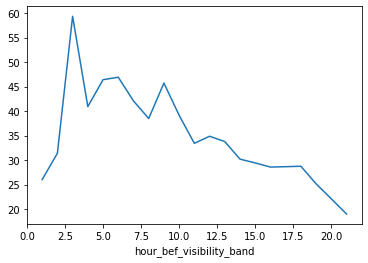

In [112]:
newtrain_copy.groupby("hour_bef_visibility_band").mean()["hour_bef_pm2.5"].plot() #각 가시성 구간 별 pm2.5 농도 평균 그래프

# 각 가시성 구간 별 pm2.5 농도 중앙값 plot

<AxesSubplot:xlabel='hour_bef_visibility_band'>

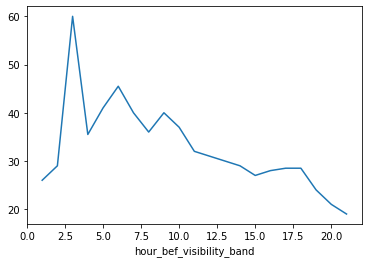

In [113]:
newtrain_copy.groupby("hour_bef_visibility_band").median()["hour_bef_pm2.5"].plot() #각 가시성 구간 별 pm2.5 농도 중앙값 그래프

# 각 구간 별 pm2.5 농도 중앙값 변수 만들기

In [114]:
newtrain_copy["hour_bef_pm2.5_median"]=0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]<=100,"hour_bef_pm2.5_median"]=26.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>100,"hour_bef_pm2.5_median"]=29.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>200,"hour_bef_pm2.5_median"]=60.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>300,"hour_bef_pm2.5_median"]=35.5
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>400,"hour_bef_pm2.5_median"]=41.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>500,"hour_bef_pm2.5_median"]=45.5
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>600,"hour_bef_pm2.5_median"]=40.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>700,"hour_bef_pm2.5_median"]=36.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>800,"hour_bef_pm2.5_median"]=40.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>900,"hour_bef_pm2.5_median"]=37.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1000,"hour_bef_pm2.5_median"]=32.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1100,"hour_bef_pm2.5_median"]=31.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1200,"hour_bef_pm2.5_median"]=30.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1300,"hour_bef_pm2.5_median"]=29.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1400,"hour_bef_pm2.5_median"]=27.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1500,"hour_bef_pm2.5_median"]=28.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1600,"hour_bef_pm2.5_median"]=28.5
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1700,"hour_bef_pm2.5_median"]=28.5
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1800,"hour_bef_pm2.5_median"]=24.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]>1900,"hour_bef_pm2.5_median"]=21.0
newtrain_copy.loc[newtrain_copy["hour_bef_visibility"]==2000,"hour_bef_pm2.5_median"]=19.0

# 결측치인 행 hour_bef_pm2.5_median 값으로 대체하기

In [115]:
temp1=list(range(1459))
newtrain_copy['hour_bef_pm2.5']
newtrain_copy['hour_bef_pm2.5_median']
for i in range(1459):
  if newtrain_copy['hour_bef_pm2.5'][i]>0:
    temp1[i] = newtrain_copy['hour_bef_pm2.5'][i]
  else:
    temp1[i] = newtrain_copy['hour_bef_pm2.5_median'][i]

In [116]:
newtrain_copy['hour_bef_pm2.5']=temp1

# pm2.5의 결측치가 대체 되었는지 확인

In [117]:
newtrain_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 1459 non-null   int64  
 1   id                         1459 non-null   int64  
 2   hour                       1459 non-null   int64  
 3   date                       1459 non-null   object 
 4   day                        1459 non-null   object 
 5   hour_bef_temperature       1459 non-null   float64
 6   hour_bef_windspeed         1459 non-null   float64
 7   hour_bef_humidity          1459 non-null   int64  
 8   hour_bef_visibility        1459 non-null   int64  
 9   hour_bef_precipitation.x   1459 non-null   int64  
 10  hour_bef_precipitation.y   1459 non-null   float64
 11  hour_bef_ozone             1459 non-null   float64
 12  hour_bef_pm10              1369 non-null   float64
 13  hour_bef_pm2.5             1459 non-null   float

# pm2.5 분포

<AxesSubplot:ylabel='Frequency'>

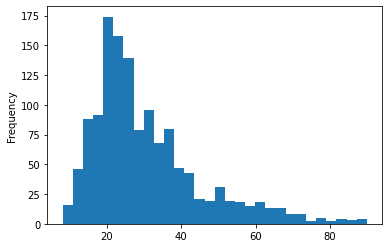

In [117]:
train_no_NA["hour_bef_pm2.5"].plot(kind="hist", bins=30)

# pm10 분포

<AxesSubplot:ylabel='Frequency'>

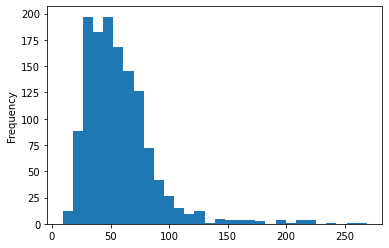

In [118]:
train_no_NA["hour_bef_pm10"].plot(kind="hist", bins=30)

# pm2.5 구간 별 pm10 중앙값으로 결측치 대체 (상관계수 0.49)

<AxesSubplot:xlabel='hour_bef_pm2.5', ylabel='hour_bef_pm10'>

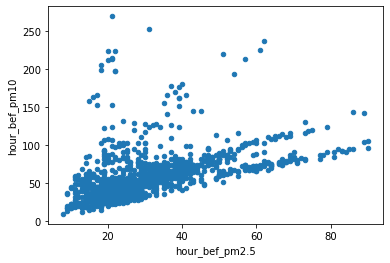

In [119]:
train_no_NA.plot(kind="scatter", x="hour_bef_pm2.5", y="hour_bef_pm10")  #hour_bef_pm10과 hour_bef_pm2.5에대한 scatterplot

<AxesSubplot:xlabel='hour_bef_pm2.5', ylabel='hour_bef_pm10'>

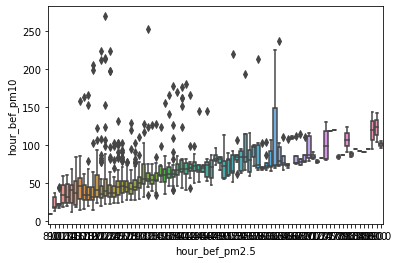

In [120]:
sns.boxplot(x = "hour_bef_pm2.5", y="hour_bef_pm10", data = train_no_NA) #hour_bef_pm10과 hour_bef_pm2.5에 따른 boxplot

# pm2.5를 10간격으로 묶어서 구간으로 만들기
#hour_bef_pm2.5가 0~10.0일때 hour_bef_pm2.5_band=1
#hour_bef_pm2.5가 10.1~20.0일때 hour_bef_pm2.5_band=2
#hour_bef_pm2.5가 20.1~30.0일때 hour_bef_pm2.5_band=3
#hour_bef_pm2.5가 30.1~40.0일때 hour_bef_pm2.5_band=4
#hour_bef_pm2.5가 40.1~50.0일때 hour_bef_pm2.5_band=5
#hour_bef_pm2.5가 50.1~60.0일때 hour_bef_pm2.5_band=6
#hour_bef_pm2.5가 60.1~70.0일때 hour_bef_pm2.5_band=7
#hour_bef_pm2.5가 70.1~80.0일때 hour_bef_pm2.5_band=8
#hour_bef_pm2.5가 80.1~90.0일때 hour_bef_pm2.5_band=9

In [118]:
newtrain_copy["hour_bef_pm2.5_band"]=0
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]<=10,"hour_bef_pm2.5_band"]=1
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>10,"hour_bef_pm2.5_band"]=2
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>20,"hour_bef_pm2.5_band"]=3
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>30,"hour_bef_pm2.5_band"]=4
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>40,"hour_bef_pm2.5_band"]=5
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>50,"hour_bef_pm2.5_band"]=6
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>60,"hour_bef_pm2.5_band"]=7
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>70,"hour_bef_pm2.5_band"]=8
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>80,"hour_bef_pm2.5_band"]=9

# 각 구간 별 pm10의 수

In [119]:
newtrain_copy.groupby("hour_bef_pm2.5_band").count()["hour_bef_pm10"] 

hour_bef_pm2.5_band
1     17
2    345
3    480
4    275
5    105
6     75
7     44
8     15
9     13
Name: hour_bef_pm10, dtype: int64

# 각 구간 별 평균 pm10

In [120]:
newtrain_copy.groupby("hour_bef_pm2.5_band").mean()["hour_bef_pm10"] #각 pm2.5 구간 별 pm10 농도 평균

hour_bef_pm2.5_band
1     23.176471
2     42.985507
3     49.779167
4     67.407273
5     73.771429
6     81.106667
7     91.545455
8     95.266667
9    101.769231
Name: hour_bef_pm10, dtype: float64

# 각 구간 별 pm10 중앙값

In [121]:
newtrain_copy.groupby("hour_bef_pm2.5_band").median()["hour_bef_pm10"] #각 pm2.5 구간 별 pm10 농도 중앙값

hour_bef_pm2.5_band
1    20.0
2    35.0
3    44.0
4    60.0
5    72.0
6    72.0
7    78.5
8    86.0
9    94.0
Name: hour_bef_pm10, dtype: float64

# 각 구간 별 pm10 농도 평균 plot

<AxesSubplot:xlabel='hour_bef_pm2.5_band'>

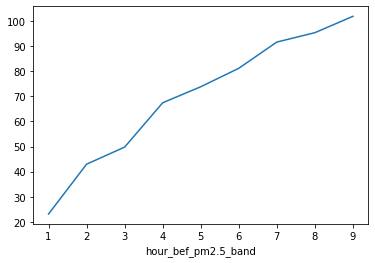

In [62]:
newtrain_copy.groupby("hour_bef_pm2.5_band").mean()["hour_bef_pm10"].plot() #각 pm2.5 구간 별 pm10 농도 평균 그래프

# 각 구간 별 pm10 농도 중앙값 plot

<AxesSubplot:xlabel='hour_bef_pm2.5_band'>

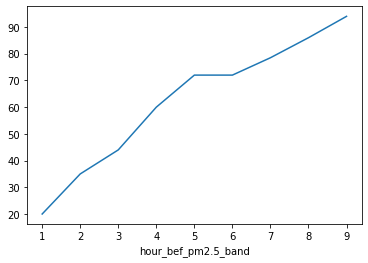

In [63]:
newtrain_copy.groupby("hour_bef_pm2.5_band").median()["hour_bef_pm10"].plot() #각 pm2.5 구간 별 pm10 농도 중앙값 그래프

# 각 구간 별 pm10 농도 중앙값 변수 만들기

In [122]:
newtrain_copy["hour_bef_pm10_median"]=0
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]<=10,"hour_bef_pm10_median"]=20.0
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>10,"hour_bef_pm10_median"]=35.0
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>20,"hour_bef_pm10_median"]=44.0
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>30,"hour_bef_pm10_median"]=60.0
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>40,"hour_bef_pm10_median"]=72.0
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>50,"hour_bef_pm10_median"]=72.0
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>60,"hour_bef_pm10_median"]=78.5
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>70,"hour_bef_pm10_median"]=86.0
newtrain_copy.loc[newtrain_copy["hour_bef_pm2.5"]>80,"hour_bef_pm10_median"]=94.0

# 결측치인 행 hour_bef_pm10_median 값으로 대체하기

In [123]:
temp2=list(range(1459))
newtrain_copy['hour_bef_pm10']
newtrain_copy['hour_bef_pm10_median']
for i in range(1459):
  if newtrain_copy['hour_bef_pm10'][i]>0:
    temp2[i] = newtrain_copy['hour_bef_pm10'][i]
  else:
    temp2[i] = newtrain_copy['hour_bef_pm10_median'][i]

In [124]:
newtrain_copy['hour_bef_pm10']=temp2

# pm10의 결측값이 대체 되었는지 확인

In [125]:
newtrain_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 1459 non-null   int64  
 1   id                         1459 non-null   int64  
 2   hour                       1459 non-null   int64  
 3   date                       1459 non-null   object 
 4   day                        1459 non-null   object 
 5   hour_bef_temperature       1459 non-null   float64
 6   hour_bef_windspeed         1459 non-null   float64
 7   hour_bef_humidity          1459 non-null   int64  
 8   hour_bef_visibility        1459 non-null   int64  
 9   hour_bef_precipitation.x   1459 non-null   int64  
 10  hour_bef_precipitation.y   1459 non-null   float64
 11  hour_bef_ozone             1459 non-null   float64
 12  hour_bef_pm10              1459 non-null   float64
 13  hour_bef_pm2.5             1459 non-null   float

# 3. 변수 선택 및 모델 구축
# Feature Engineering & Initial Modeling

KNN 모형
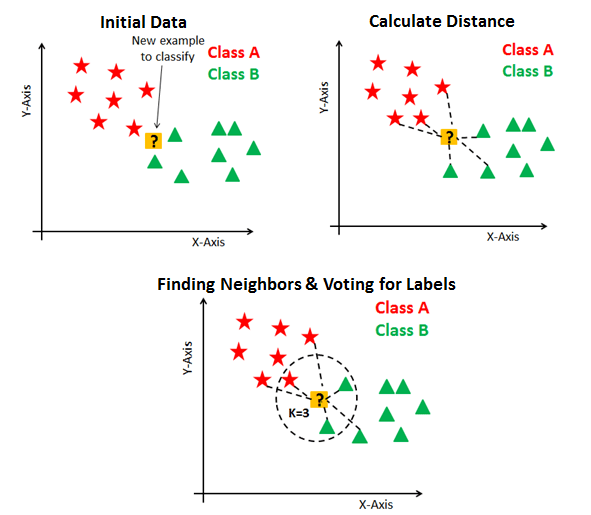

In [128]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_jobs = -1)

랜덤 포레스트 모형
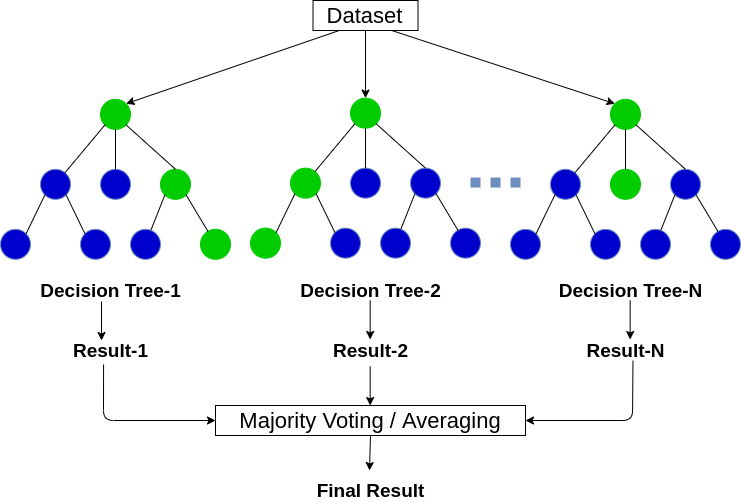

In [129]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()